In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
def get_sval_scores(svals, n):
    """For computational efficiency, just compute svd once"""
    svals = np.asarray(svals).reshape(-1)
    regions = sum(svals > 0)

    schatten1 = sum(svals)
    evals = svals**2
    vec = np.asarray([
        i / n + np.sqrt(np.sum(evals[i:]) / n) for i in range(len(evals)+1)
    ])
    hstar = min(vec)

    return regions, hstar, schatten1

In [18]:
dataframes = []

datasets = ['train', 'test', 'ood_22', 'ood_45']
metrics = ['01_error', 'loss']
sval_metrics = []
for vals in ['0/1', 'true_label', 'est_label', 'est_proba']:
    for mat in ['full', 'pen']:
        sval_metrics.append(mat + '-' + vals)

columns = [
    'Architecture', 'run', 'n_parameters', 
]
for dataset in datasets:
    for metric in metrics:
        columns.append(metric + '-' + dataset)
    for metric in sval_metrics:
        for score in ['regions', 'h*', 'Schatten1']:
            columns.append(score + '-' + metric + '-' + dataset)


n = 1000

for run in range(10):
    results = np.load(f'rotation_results/results_{run}.npz', allow_pickle=True)
    for arch in ['w', 'd']:
        d = results[f'result_{arch}'].flatten()[0]
        sub_mat = []
        for dataset in datasets:
            for metric in metrics:
                sub_mat.append(np.asarray(d[dataset][metric]))
                
            for metric in sval_metrics:
                svals_list = d[dataset][metric]
                n_regions, hstars, schatten1s = list(zip(*
                    [get_sval_scores(svals, n) for svals in svals_list]
                ))
                sub_mat.append(n_regions)
                sub_mat.append(hstars)
                sub_mat.append(schatten1s)
        sub_mat = [
            ['width' if arch == 'w' else 'depth'] * len(sub_mat[0]),
            [run] * len(sub_mat[0]),
            d['n_parameters'],
        ] + sub_mat
        dataframes.append(pd.DataFrame({c: m for c, m in zip(columns, sub_mat)}))

In [19]:
df = pd.concat(dataframes, ignore_index=True)

In [20]:
df.to_csv('./rotation_results/results_table.csv', index=False)

In [21]:
df = pd.read_csv('./rotation_results/results_table.csv')

In [22]:
df

,Architecture,run,n_parameters,01_error-train,loss-train,regions-full-0/1-train,h*-full-0/1-train,Schatten1-full-0/1-train,regions-pen-0/1-train,h*-pen-0/1-train,...,Schatten1-full-est_label-ood_45,regions-pen-est_label-ood_45,h*-pen-est_label-ood_45,Schatten1-pen-est_label-ood_45,regions-full-est_proba-ood_45,h*-full-est_proba-ood_45,Schatten1-full-est_proba-ood_45,regions-pen-est_proba-ood_45,h*-pen-est_proba-ood_45,Schatten1-pen-est_proba-ood_45
0,width,0,11,0.500,0.693147,1,0.001,31.622777,1,0.001,...,31.622777,1,0.001,31.622777,0,0.000000,0.000000,0,0.000000,0.000000
1,width,0,27,0.413,0.664774,6,0.006,54.309529,117,0.117,...,52.671379,123,0.123,159.531800,5,0.005000,13.119663,123,0.079401,33.634918
2,width,0,49,0.330,0.605671,17,0.017,108.962572,743,0.743,...,110.096967,756,0.756,770.652476,17,0.017000,40.471792,756,0.335684,239.959135
3,width,0,77,0.264,0.512581,44,0.044,165.531962,872,0.872,...,160.083041,860,0.860,876.191496,41,0.041000,83.044555,860,0.454168,358.090771
4,width,0,111,0.262,0.500701,82,0.082,226.835404,1000,1.000,...,229.120106,1000,1.000,1000.000000,78,0.074193,112.070156,1000,0.552336,465.472038
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
865,depth,9,5961,0.204,0.397965,736,0.736,825.373766,925,0.925,...,818.034009,938,0.938,944.937254,726,0.546579,454.561618,938,0.627147,520.859261
866,depth,9,6381,0.275,0.521434,548,0.548,686.903953,1000,1.000,...,679.333862,998,0.998,998.732051,532,0.297619,250.466182,998,0.474915,361.644827
867,depth,9,6801,0.206,0.439577,751,0.751,837.460549,998,0.998,...,872.887273,995,0.995,996.449490,800,0.584003,471.960346,995,0.622673,543.987309
868,depth,9,7221,0.230,0.448977,830,0.830,892.547567,988,0.988,...,892.449528,985,0.985,988.000000,833,0.527143,442.959187,985,0.607261,493.925277


In [29]:
plot_datasets = ['train', 'test', 'ood_22', 'ood_45']
plot_metrics = [
    '01_error',
    'loss',
    'regions-full-0/1',
    'h*-full-0/1',
    'Schatten1-full-0/1',
    'regions-pen-0/1',
    'h*-pen-0/1',
    'Schatten1-pen-0/1',
]
row_y = [
    [f'{pm}-{pd}' for pd in plot_datasets]
    for pm in plot_metrics
]

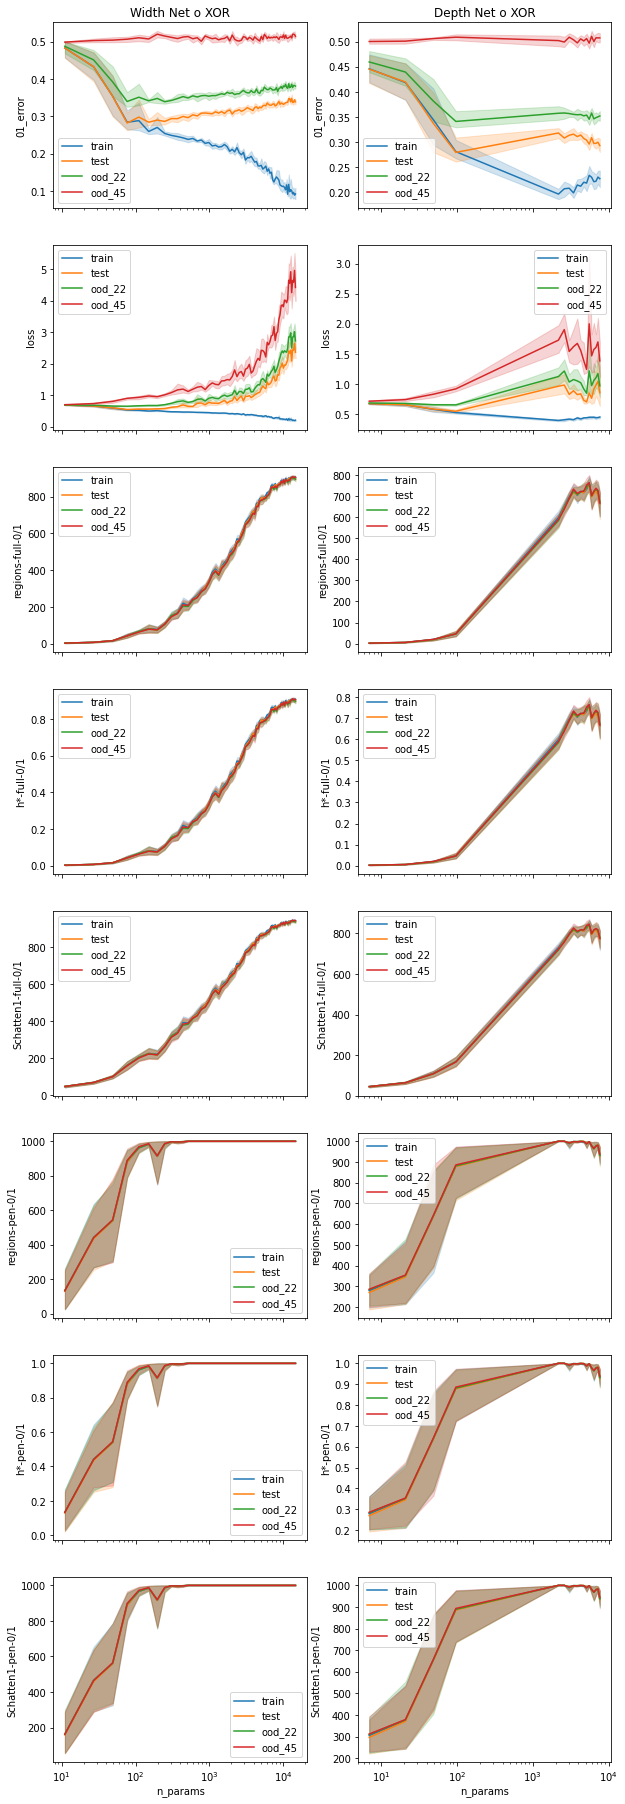

In [30]:
fig, axes = plt.subplots(len(row_y), 2, figsize=(10, 4*len(row_y)), sharex='col')#, sharex='col')#, sharey='row')
for col, arch in enumerate(['width', 'depth']):
    for row, metric in enumerate(plot_metrics):
        ax = axes[row, col]
        for ds in plot_datasets:
            sns.lineplot(
                data=df[df['Architecture'] == arch],
                x='n_parameters', y=f'{metric}-{ds}',
                ax=ax, label=ds)
        ax.set_ylabel(metric)
axes[0, 0].set_title('Width Net o XOR')
axes[0, 1].set_title('Depth Net o XOR')
for ax in (axes[-1, 0], axes[-1, 1]):
    ax.set_xlabel('n_params')
    ax.set_xscale('log')

In [37]:
df.groupby(['Architecture', 'n_parameters']).mean()['Schatten1-pen-0/1-train', ]

run  01_error-train  loss-train  \
Architecture n_parameters                                    
depth        7             4.5          0.4458    0.672760   
             21            4.5          0.4185    0.652652   
             49            4.5          0.3444    0.578616   
             97            4.5          0.2809    0.524375   
             2181          4.5          0.1964    0.394246   
...                        ...             ...         ...   
width        13131         4.5          0.1010    0.221577   
             13531         4.5          0.0926    0.199731   
             13937         4.5          0.0964    0.208063   
             14349         4.5          0.0892    0.194368   
             14767         4.5          0.0925    0.205234   

                           regions-full-0/1-train  h*-full-0/1-train  \
Architecture n_parameters                                              
depth        7                                2.3             0.0023   
             21                               5.9             0.0059   
             49                              20.1             0.0201   
             97                              45.9             0.0459   
             2181                           597.3             0.5973   
...                                           ...                ...   
width        13131                          901.7             0.9017   
             13531                          908.0             0.9080   
             13937                          902.8             0.9028   
             14349                          908.6             0.9086   
             14767                          903.8             0.9038   

                           Schatten1-full-0/1-train  regions-pen-0/1-train  \
Architecture n_parameters                                                    
depth        7                            44.825197                  279.4   
             21                           64.082364                  350.3   
             49                          109.758385                  638.6   
             97                          168.100178                  880.9   
             2181                        729.068411                 1000.0   
...                                             ...                    ...   
width        13131                       939.847592                 1000.0   
             13531                       944.362909                 1000.0   
             13937                       940.880989                 1000.0   
             14349                       944.705083                 1000.0   
             14767                       941.763551                 1000.0   

                           h*-pen-0/1-train  Schatten1-pen-0/1-train  \
Architecture n_parameters                                              
depth        7                       0.2794               305.150962   
             21                      0.3503               374.725824   
             49                      0.6386               654.493708   
             97                      0.8809               888.550480   
             2181                    1.0000              1000.000000   
...                                     ...                      ...   
width        13131                   1.0000              1000.000000   
             13531                   1.0000              1000.000000   
             13937                   1.0000              1000.000000   
             14349                   1.0000              1000.000000   
             14767                   1.0000              1000.000000   

                           regions-full-true_label-train  ...  \
Architecture n_parameters                                 ...   
depth        7                                       2.3  ...   
             21                                      5.9  ...   
             49                                     20.1  ...   
      